In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade opencv-python==4.4.0.40

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.4 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Import Packages

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [ ]:
cv2.__version__

'4.4.0'

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Our configuration file

In [ ]:
def detect_person(frame, net, ln, busIdx=0):
	# grab the dimensions of the frame and  initialize the list of
	# results
	(H, W) = frame.shape[:2]
	results = []
	class_ids = []

    # construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (1280, 1280),
		swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)

	# initialize our lists of detected bounding boxes, centroids, and
	# confidences, respectively
	boxes = []
	centroids = []
	confidences = []

    # loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter detections by (1) ensuring that the object
			# detected was a person and (2) that the minimum
			# confidence is met
			if classID == busIdx and confidence > 0.5:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates,
				# centroids, and confidences
				boxes.append([x, y, int(width), int(height)])
				centroids.append((centerX, centerY))
				confidences.append(float(confidence))
				class_ids.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.1)

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# update our results list to consist of the person
			# prediction probability, bounding box coordinates,
			# and the centroid
			r = (confidences[i], (x, y, x + w, y + h), centroids[i], class_ids[i])
			results.append(r)

	# return the list of results
	return results

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "/content/drive/MyDrive/yolov4/tjtrim1.mp4",
    "output": "hasil-tes_2_1.avi",
    "display": 1
}

In [ ]:
# load the COCO class labels our YOLO model was trained on
LABELS = open("/content/drive/MyDrive/yolov4/classes.txt").read().strip().split("\n")

# derive the paths to the YOLO weights and model configuration
weightsPath = '/content/drive/MyDrive/yolov4/training/yolov4-custom_best.weights'
configPath = '/content/drive/MyDrive/yolov4/yolov4-custom.cfg'

In [ ]:
class Config:

    # boolean indicating if NVIDIA CUDA GPU should be used
    USE_GPU = False

# instantiate our Config object
config = Config()

In [ ]:
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# check if we are going to use GPU
#if config.USE_GPU:
	# set CUDA as the preferable backend and target
print("[INFO] setting preferable backend and target to CUDA...")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

[INFO] loading YOLO from disk...
[INFO] setting preferable backend and target to CUDA...


In [ ]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream and pointer to output video file
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

[INFO] accessing video stream...


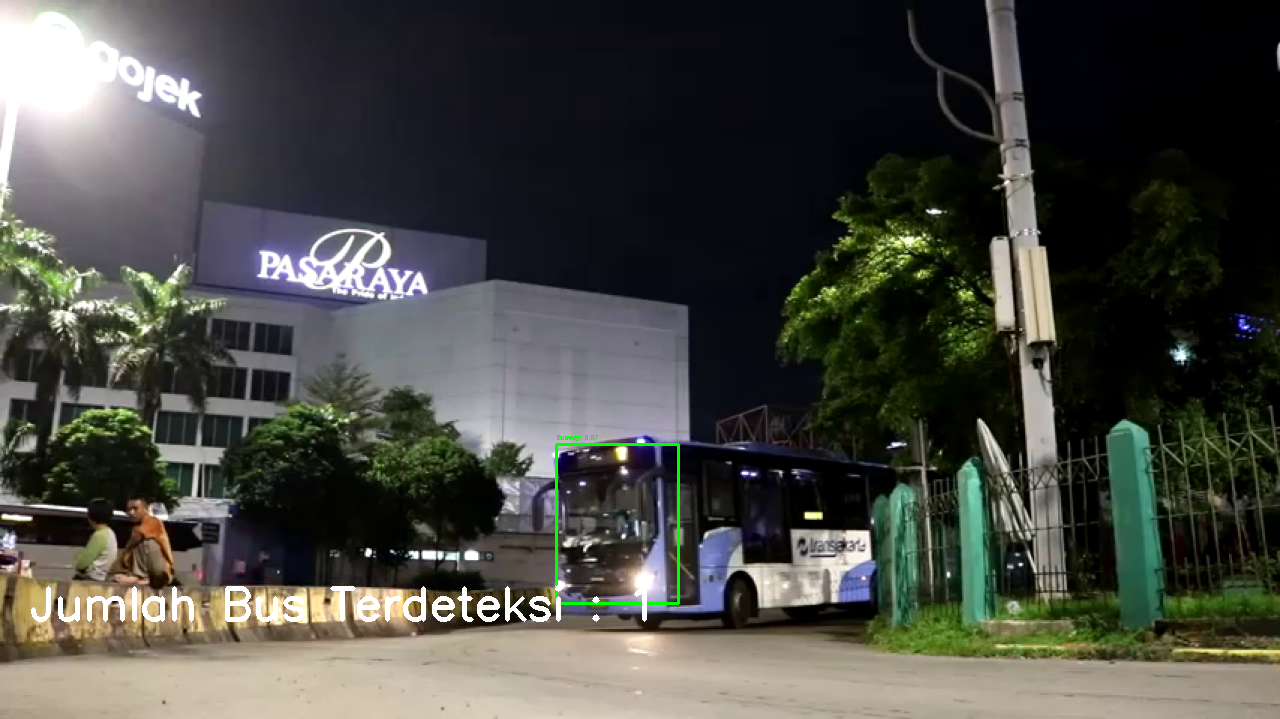

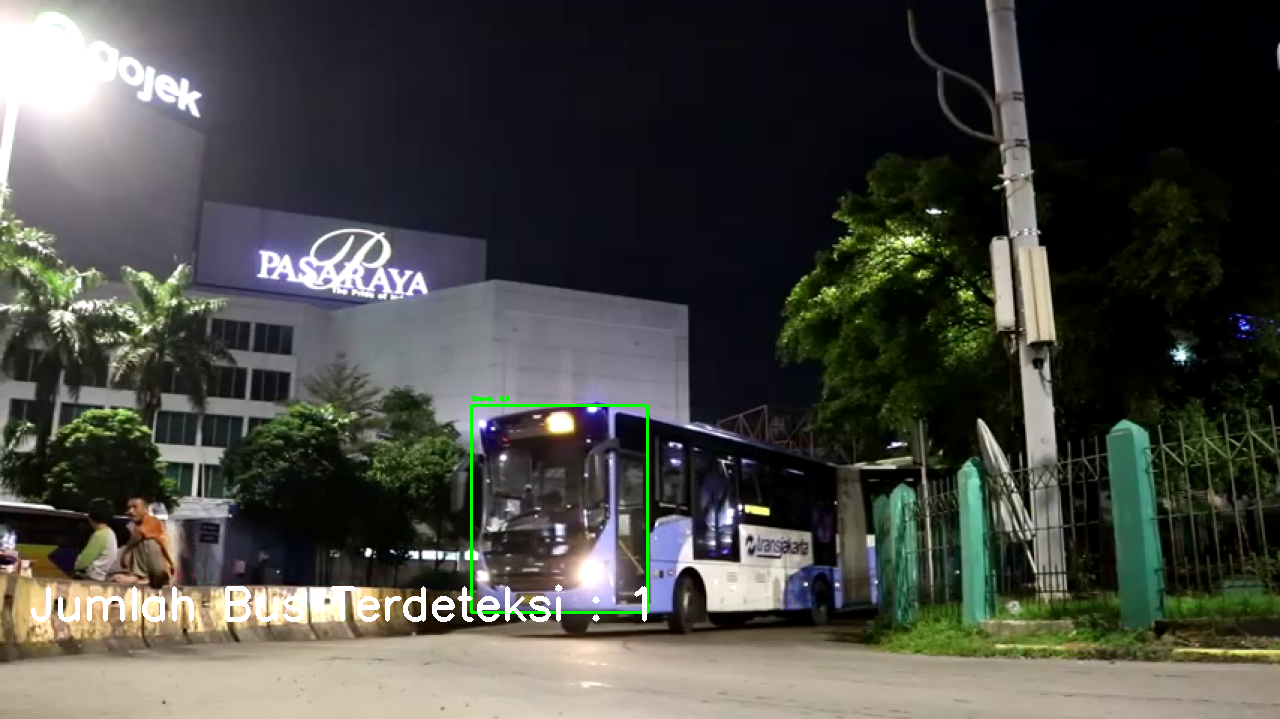

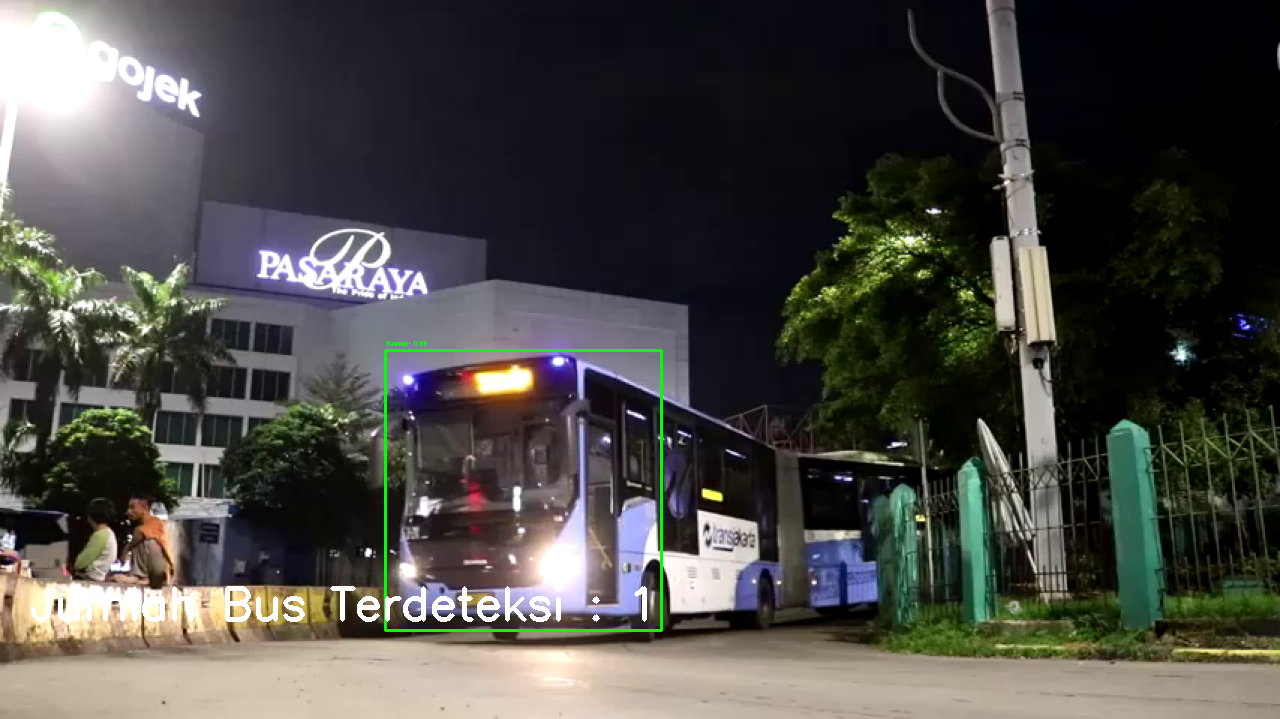

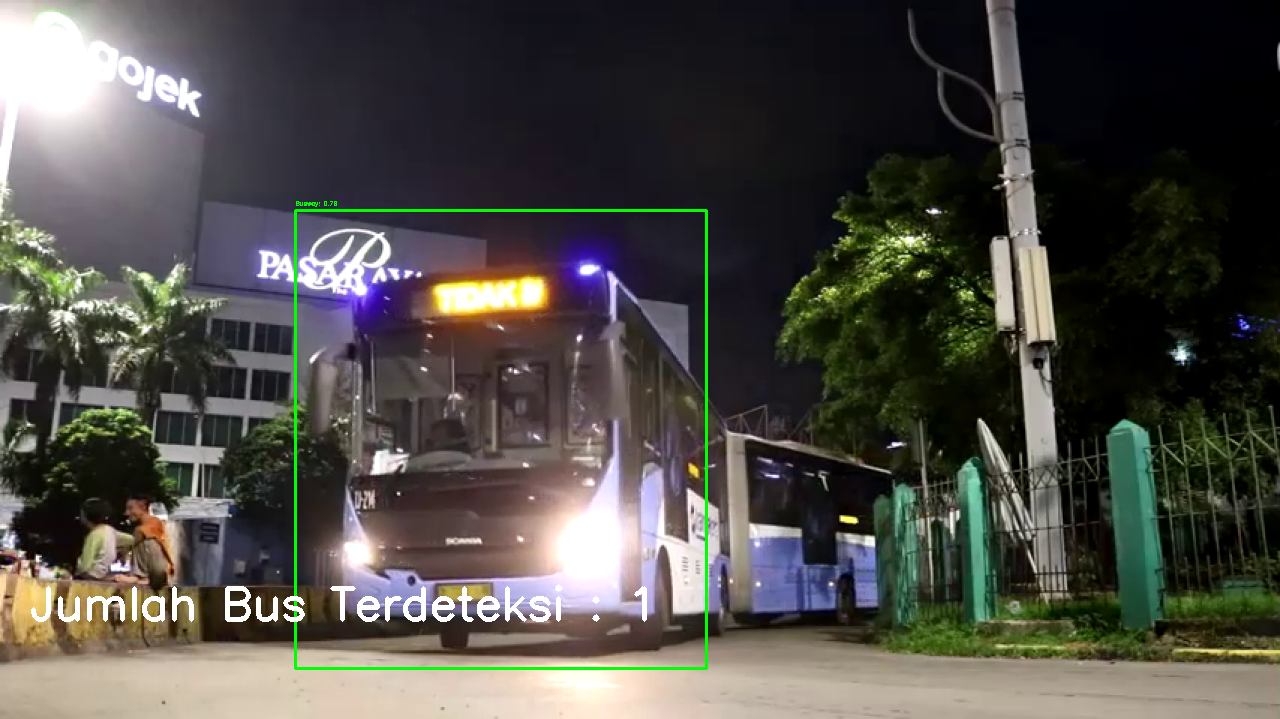

In [ ]:
from google.colab.patches import cv2_imshow

# loop over the frames from the video stream
count =0
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# resize the frame and then detect people (and only people) in it
	frame = imutils.resize(frame, width=1280)
	results = detect_person(frame, net, ln,
		busIdx=LABELS.index("Busway"))

    # loop over the results
	for (i, (prob, bbox, centroid, classID)) in enumerate(results):
		# extract the bounding box and centroid coordinates, then
		# initialize the color of the annotation
		(startX, startY, endX, endY) = bbox
		(cX, cY) = centroid
		color = (0, 255, 0)

		# draw (1) a bounding box around the person and (2) the
		# centroid coordinates of the person,
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		# cv2.circle(frame, (cX, cY), 5, color, 1)
	
		# put label text + its confidence score	
		hasil_deteksi_skor = LABELS[classID] + ": " + str(round(prob, 2))
	
		cv2.putText(frame, hasil_deteksi_skor, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 255, 0), 1)
	
	text_banyak_objek = "Jumlah Bus Terdeteksi : {}".format(len(results))
	cv2.putText(frame, text_banyak_objek, (30, frame.shape[0] - 100),
	            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

    # check to see if the output frame should be displayed to our
	# screen
	if args["display"] > 0:
		# show the output frame
		cv2_imshow(frame)
		key = cv2.waitKey(1) & 0xFF

		# if the `q` key was pressed, break from the loop
		if key == ord("q"):
			break

	# if an output video file path has been supplied and the video
	# writer has not been initialized, do so now
	if args["output"] != "" and writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 25,
			(frame.shape[1], frame.shape[0]), True)

	# if the video writer is not None, write the frame to the output
	# video file
	if writer is not None:
		writer.write(frame)
	count+=30
	vs.set(cv2.CAP_PROP_POS_FRAMES, count)

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()